In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import enet_path
from sklearn.feature_selection import SelectFromModel  
from sklearn.preprocessing import StandardScaler  
from sklearn.preprocessing import MinMaxScaler  



In [136]:
import re 
# 读取CSV文件  
data = pd.read_csv(r'C:\Users\13212\Desktop\省肿瘤\3\术前 05.csv', encoding='GBK',low_memory=False)  # 术前.csv!!!
 
# 特征变量提取，即除了最后一列以外的所有列  
X_raw = data.iloc[:, :-1]  
  
# 响应变量，即最后一列  
y = data.iloc[:, -1]  
  







In [137]:
# 数据清洗：将空字符串替换为NaN，并处理NaN值  
X_raw.replace(' ', pd.NA, inplace=True)  # 假设空字符串是不需要的值  
# 只选择数值列来计算中位数  
numeric_columns = X_raw.select_dtypes(include=[np.number]).columns  
  
# 计算数值列的中位数  
median_values = X_raw[numeric_columns].median()  
  
# 使用计算出的中位数填充NaN值，但仅限于数值列  
X_raw[numeric_columns] = X_raw[numeric_columns].fillna(median_values)


  
# def extract_numbers(s):  
   #  numbers = re.findall(r'\d+(\.\d+)?', str(s))  
    # if numbers:  
        # 确保numbers列表不为空，并且第一个元素不是空字符串（尽管这在正常情况下不会发生）  
        # if numbers[0]:  
           #  return float(numbers[0])  
        # else:  
            # 如果numbers列表的第一个元素是空字符串（这实际上不应该发生），返回0  
           # return 0  
    # else:  
        # 如果没有找到任何数字，返回0  
       #  return 0

  
# 只选择非数值列并应用extract_numbers函数  
# 只选择非数值列，并应用extract_numbers函数到每个元素  
non_numeric_columns = X_raw.select_dtypes(exclude=[np.number]).columns  
X_raw[non_numeric_columns] = X_raw[non_numeric_columns].apply(lambda x: x.map(extract_numbers) if isinstance(x, pd.Series) else extract_numbers(x)) 
  
# 只选择数值列来计算中位数  
numeric_columns = X_raw.select_dtypes(include=[np.number]).columns  
  
# 计算数值列的中位数  
median_values = X_raw[numeric_columns].median()  
  
# 使用计算出的中位数填充NaN值，但仅限于数值列  
X_raw[numeric_columns] = X_raw[numeric_columns].fillna(median_values)  
  
# 保存处理后的数据集到CSV文件  
# X_raw.to_csv(r'C:\Users\13212\Desktop\省肿瘤\3\processed_03.csv', index=False)  # index=False表示不保存行索引



In [138]:
numeric_cols = X_raw.select_dtypes(exclude=['object']).columns  # 假设非数值列是object类型  
for col in X_raw.columns.difference(numeric_cols):  
    X_raw[col] = X_raw[col].apply(extract_numbers)  
# 确保所有特征列都是数值型  
def check_numeric(df):  
    non_numeric_cols = df.select_dtypes(exclude=['int64', 'float64', 'float32']).columns  
    if non_numeric_cols.any():  
        raise ValueError(f"The following columns are not numeric: {non_numeric_cols.tolist()}")  
  
check_numeric(X_raw)  # 这将抛出错误，如果有任何非数值列    
# 特征变量标准化  
scaler = StandardScaler()  
X = scaler.fit_transform(X_raw)  




In [139]:
# 模型估计  
model = ElasticNet(alpha=0.1, l1_ratio=0.5)  
model.fit(X, y)  
print('模型得分：\n', model.score(X, y))  
result = pd.DataFrame({'变量': X_raw.columns, '系数': model.coef_})  
print('最优回归系数：\n', result)  #   只包含（或应该只包含）数值列，可以直接用于模型拟合  


模型得分：
 0.03392303870247282
最优回归系数：
                  变量       系数
0              患者年龄 -0.00000
1             ptsex  0.01203
2           KPS评分分级 -0.00000
3              吞咽困难  0.00000
4              进食呛咳  0.00000
..              ...      ...
143          血小板减少症  0.00000
144      厌食Anorexia  0.00000
145              厌食  0.00000
146  便秘Constipation  0.00000
147              便秘  0.00000

[148 rows x 2 columns]


In [140]:
# 使用ElasticNetCV进行交叉验证并选择最优alpha  
alphas = np.logspace(-3, 0, 100)  
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
model_cv = ElasticNetCV(cv=kfold, alphas=alphas, max_iter=10000)  
model_cv.fit(X, y)  
print('最优惩罚系数：\n', model_cv.alpha_)  
  


最优惩罚系数：
 0.01873817422860384


In [141]:
# 使用最优alpha和平均l1_ratio来估计最优的l1_ratio  
best_alpha = model_cv.alpha_  
best_l1_ratio = model_cv.l1_ratio_.mean()  
best_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000)  
best_model.fit(X, y)  # 使用相同的标准化数据X来拟合最终模型  
print('对于最优alpha的l1_ratio估计值：\n', best_model.l1_ratio)  
print('最终模型得分：\n', best_model.score(X, y))  # 可以选择打印最终模型的得分

对于最优alpha的l1_ratio估计值：
 0.5
最终模型得分：
 0.12457706320221584


C:\Users\13212\AppData\Local\Temp\ipykernel_6872\768712844.py:43: UserWarning: Glyph 24739 (\N{CJK UNIFIED IDEOGRAPH-60A3}) missing from current font.
  plt.savefig(r'C:\Users\13212\Desktop\省肿瘤\分析2\coefficient_path2.png')
C:\Users\13212\AppData\Local\Temp\ipykernel_6872\768712844.py:43: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from current font.
  plt.savefig(r'C:\Users\13212\Desktop\省肿瘤\分析2\coefficient_path2.png')
C:\Users\13212\AppData\Local\Temp\ipykernel_6872\768712844.py:43: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.savefig(r'C:\Users\13212\Desktop\省肿瘤\分析2\coefficient_path2.png')
C:\Users\13212\AppData\Local\Temp\ipykernel_6872\768712844.py:43: UserWarning: Glyph 40836 (\N{CJK UNIFIED IDEOGRAPH-9F84}) missing from current font.
  plt.savefig(r'C:\Users\13212\Desktop\省肿瘤\分析2\coefficient_path2.png')
C:\Users\13212\AppData\Local\Temp\ipykernel_6872\768712844.py:43: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOG

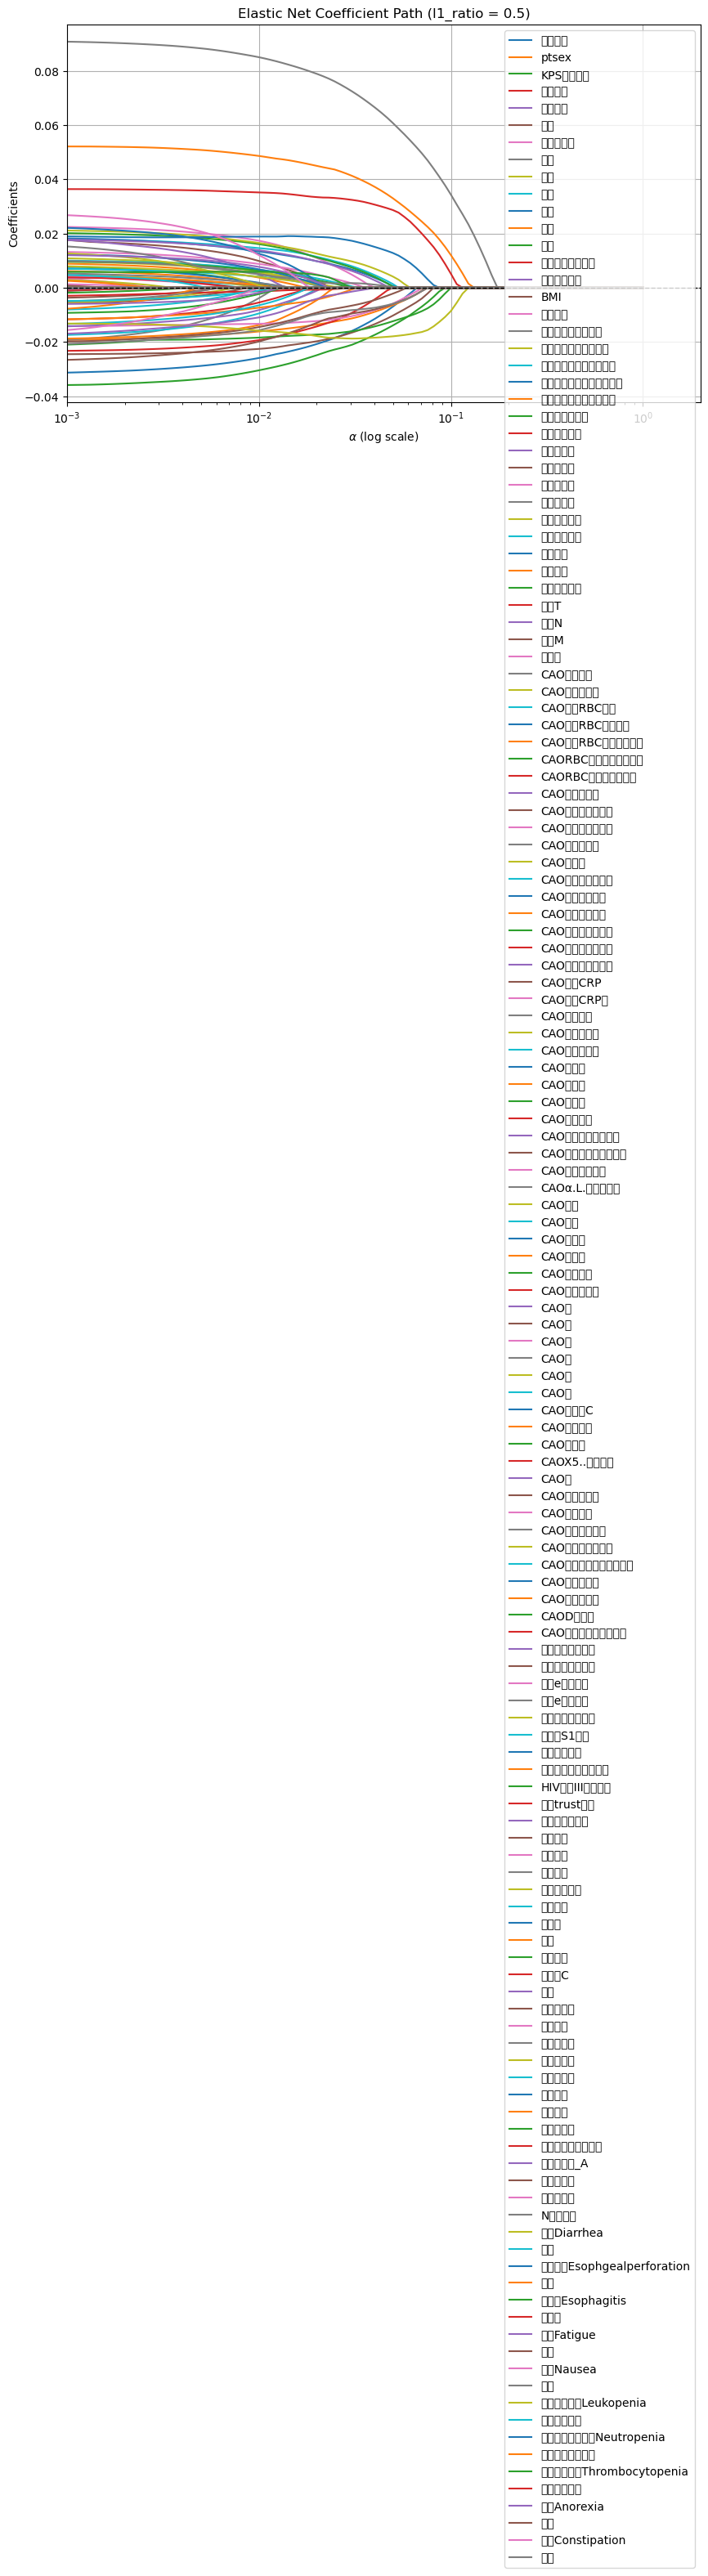

In [142]:

coefs = []  # 存储每个alpha对应的系数    
    
for alpha in alphas:    
    enet = ElasticNet(alpha=alpha, l1_ratio=best_model.l1_ratio, fit_intercept=False)  # 修复了参数传递的问题  
    enet.fit(X, y)    
    coefs.append(enet.coef_)    
    
coefs = np.array(coefs)  
  
# 绘制系数路径图  
plt.figure(figsize=(10, 6))  
ax = plt.gca()  
for i, col in enumerate(X_raw.columns):  
    ax.plot(alphas, coefs[:, i], label=col)  
  
# 假设 alphas 是你的 alpha 值数组  
current_max_alpha = max(alphas)  
  
# 转换当前最大和最小alpha值为对数形式  
log_max_alpha = np.log10(current_max_alpha)  
log_min_alpha = np.log10(min(alphas))  
  
# 在对数尺度上进行扩展，例如扩展10%  
log_extended_max_alpha = log_max_alpha + 0.1 * (log_max_alpha - log_min_alpha)  
  
# 转换回原始尺度  
extended_max_alpha = 10 ** log_extended_max_alpha  
  
# 设置X轴为对数刻度  
ax.set_xscale('log')  
  
# 设置X轴的范围，使用对数扩展后的最大值  
plt.xlim(xmin=min(alphas), xmax=extended_max_alpha)  
  
plt.xlabel(r'$\alpha$ (log scale)')  
plt.ylabel('Coefficients')  
plt.title('Elastic Net Coefficient Path (l1_ratio = 0.5)')  
plt.axhline(0, linestyle='--', linewidth=1, color='k')  
plt.legend(loc='best') # 中文标识 
plt.grid()  
  
# 保存图像到指定路径  
plt.savefig(r'C:\Users\13212\Desktop\省肿瘤\分析2\coefficient_path2.png')  
  
# 显示图像  
plt.show()

In [143]:
# 获取系数和列名  
coefficients = model.coef_  
column_names = X_raw.columns  
  
# 计算系数的绝对值，并获取排序索引  
sorted_indices = np.argsort(np.abs(coefficients))[::-1]  # [::-1] 是为了逆序排序，即绝对值由大到小  
  
# 使用排序后的索引来重新排列列名和系数  
sorted_column_names = column_names[sorted_indices]  
sorted_coefficients = coefficients[sorted_indices]  
  
# 创建一个新的DataFrame，其中包含排序后的列名和系数  
result = pd.DataFrame({'变量': sorted_column_names, '系数': sorted_coefficients})  
  
print(f'回归系数（按绝对值由大到小排序）：\n', result)


回归系数（按绝对值由大到小排序）：
                变量        系数
0           N阳性病例  0.034329
1           ptsex  0.012030
2          小圆上皮细胞 -0.008556
3         CAO白球比例  0.005141
4      CAO平均RBC体积  0.000000
..            ...       ...
143       乙肝e抗原定量 -0.000000
144      乙肝表面抗体定量 -0.000000
145      乙肝表面抗原定量 -0.000000
146  CAO纤维蛋白原降解产物 -0.000000
147          患者年龄 -0.000000

[148 rows x 2 columns]


In [144]:
# 获取系数和列名  
coefficients = model.coef_  
column_names = X_raw.columns  
  
# 计算系数的绝对值，并获取排序索引  
sorted_indices = np.argsort(np.abs(coefficients))[::-1]  
  
# 使用排序后的索引来重新排列列名和系数  
sorted_column_names = column_names[sorted_indices]  
sorted_coefficients = coefficients[sorted_indices]  
  
# 创建一个新的DataFrame，其中包含排序后的列名和系数  
result = pd.DataFrame({'变量': sorted_column_names, '系数': sorted_coefficients})  
  
# 只展示前60行（即所有特征的系数，但如果系数数量超过60，则只展示前60个最大的系数）  
print(f'回归系数（按绝对值由大到小排序，前60例）：\n', result.head(60))

回归系数（按绝对值由大到小排序，前60例）：
                 变量        系数
0            N阳性病例  0.034329
1            ptsex  0.012030
2           小圆上皮细胞 -0.008556
3          CAO白球比例  0.005141
4       CAO平均RBC体积  0.000000
5         CAO血小板压积  0.000000
6         CAO红细胞压积  0.000000
7       CAO嗜酸性细胞数目  0.000000
8        CAO单核细胞数目 -0.000000
9        CAO淋巴细胞数目  0.000000
10      CAO中性粒细胞数目  0.000000
11          CAO白细胞  0.000000
12      CAO血小板分布宽度  0.000000
13    CAO平均RBC血红蛋白  0.000000
14      CAO平均血小板体积  0.000000
15      CAO嗜碱性细胞数目 -0.000000
16        CAO血小板数目  0.000000
17   CAORBC分布宽度标准差  0.000000
18  CAORBC分布宽度变异系数  0.000000
19  CAO平均RBC血红蛋白浓度  0.000000
20              便秘  0.000000
21      CAO网织红细胞计数 -0.000000
22        CAO超敏CRP -0.000000
23       CAO超敏CRP值 -0.000000
24         CAO总胆红素  0.000000
25        CAO直接胆红素  0.000000
26        CAO间接胆红素  0.000000
27          CAO总蛋白  0.000000
28          CAO白蛋白  0.000000
29          CAO球蛋白  0.000000
30     CAO丙氨酸氨基转移酶 -0.000000
31    CAO门冬氨酸氨基转移酶  0.000000
32       CAO谷氨酰转肽酶 

In [145]:

# 使用SelectFromModel和最优ElasticNet模型选择特征  
coef_median = np.median(np.abs(best_model.coef_))  
coef_mean = np.mean(np.abs(best_model.coef_))  
threshold = (coef_median + coef_mean) / 2  
sfm = SelectFromModel(best_model, threshold=threshold, prefit=True)  # 使用prefit=True因为我们已经拟合了模型  
X_selected = sfm.transform(X)  # X_selected将是一个NumPy数组  
  
# 使用原始列名获取选择的特征名称  
selected_feature_indices = sfm.get_support(indices=True)  
selected_features = X_raw.columns[selected_feature_indices].tolist()  # 使用X_raw.columns而不是original_columns（如果original_columns是X_raw.columns的副本）  
  
print(selected_features)

['患者年龄', 'ptsex', 'KPS评分分级', 'BMI', '既往病史选项心血管疾病', '重复癌', 'CAO平均RBC体积', 'CAO血小板分布宽度', 'CAO白细胞', 'CAO淋巴细胞数目', 'CAO单核细胞数目', 'CAO嗜碱性细胞数目', 'CAO超敏CRP', 'CAO超敏CRP值', 'CAO直接胆红素', 'CAO球蛋白', 'CAO白球比例', 'CAO丙氨酸氨基转移酶', 'CAO肌酐', 'CAO甘油三脂', 'CAO钾', 'CAO钙', 'CAO镁', 'CAO胱抑素C', 'CAO总胆汁酸', 'CAO脂肪酶', 'CAO纤维蛋白原', '乙肝表面抗体定量', '丙型肝炎抗体', 'HIV抗体III初筛试验', '梅毒螺旋体抗体', '结晶数量', '上皮细胞', '小圆上皮细胞', '沉渣红细胞_A', 'N阳性病例']


In [105]:
import seaborn as sns  
import matplotlib.pyplot as plt  
import pandas as pd  
import numpy as np  
from sklearn.feature_selection import SelectFromModel 

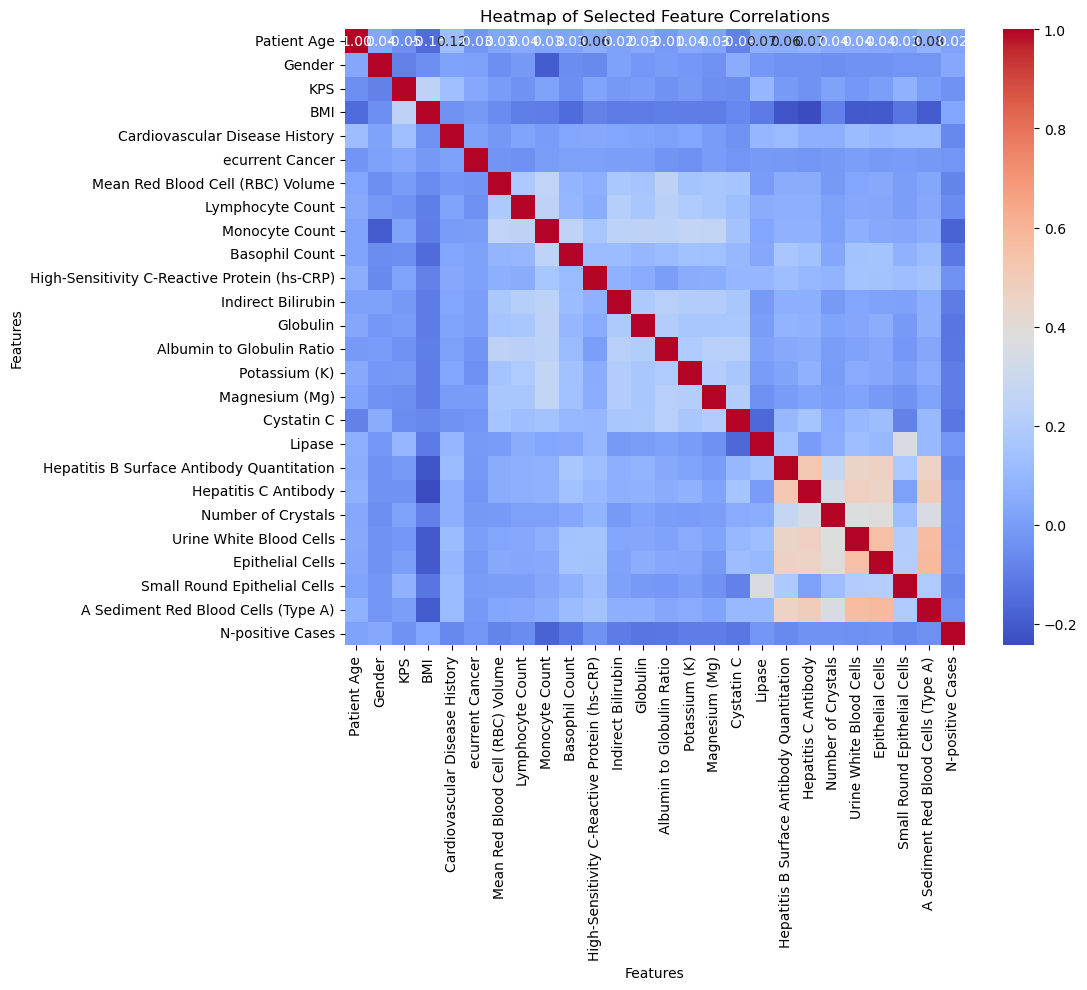

In [38]:
# 使用 SelectFromModel 选择特征  
coef_median = np.median(np.abs(best_model.coef_))  
coef_mean = np.mean(np.abs(best_model.coef_))  
threshold = (coef_median + coef_mean) / 2  
sfm = SelectFromModel(best_model, threshold=threshold, prefit=True)  
X_selected = sfm.transform(X)  
selected_feature_indices = sfm.get_support(indices=True)  
selected_features = X_raw.columns[selected_feature_indices].tolist()  
  
# 从原始数据集中选择筛选后的特征  
X_selected_df = X_raw[selected_features]  
  
# 计算相关性矩阵  
correlation_matrix = X_selected_df.corr()  
  
# 绘制热力图  
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')  
plt.title('Heatmap of Selected Feature Correlations')  
plt.xlabel('Features')  
plt.ylabel('Features') 
plt.savefig(r'C:\Users\13212\Desktop\省肿瘤\3\Heatmap of Selected Feature Correlations.png')
plt.show()